<a href="https://colab.research.google.com/github/chi-hun/dacon/blob/main/%EC%9B%94%EA%B0%84_%EB%8D%B0%EC%9D%B4%EC%BD%98_%EC%98%88%EC%88%A0_%EC%9E%91%ED%92%88_%ED%99%94%EA%B0%80_%EB%B6%84%EB%A5%98_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

월간 데이콘 예술 작품 화가 분류 AI 경진대회 https://dacon.io/competitions/official/236006/overview/description

# module

In [121]:
import numpy as np
import pandas as pd
import glob
import cv2
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A

In [4]:
!unzip -qq  '/content/drive/MyDrive/Colab Notebooks/데이콘/월간 데이콘 예술 작품 화가 분류/open.zip'

# EDA

In [23]:
train = pd.read_csv('/content/train.csv', index_col='id')

In [24]:
train

,img_path,artist
id,,
0,./train/0000.jpg,Diego Velazquez
1,./train/0001.jpg,Vincent van Gogh
2,./train/0002.jpg,Claude Monet
3,./train/0003.jpg,Edgar Degas
4,./train/0004.jpg,Hieronymus Bosch
...,...,...
5906,./train/5906.jpg,Pieter Bruegel
5907,./train/5907.jpg,Peter Paul Rubens
5908,./train/5908.jpg,Paul Gauguin


In [26]:
train['img_path'] = sorted(glob.glob('/content/train/*'))

In [27]:
def img_size(x):
    img = cv2.imread(x)
    return img.shape

train['img_shape'] = train['img_path'].apply(img_size)

In [44]:
def image_width(x):
    return x[1]
train['width'] = train['img_shape'].apply(image_width)

def image_height(x):
    return x[0]
train['height'] = train['img_shape'].apply(image_height)

In [45]:
train.head()

,img_path,artist,img_shape,width,height
id,,,,,
0,/content/train/0000.jpg,Diego Velazquez,"(1300, 1024, 3)",1024,1300
1,/content/train/0001.jpg,Vincent van Gogh,"(1024, 568, 3)",568,1024
2,/content/train/0002.jpg,Claude Monet,"(722, 1024, 3)",1024,722
3,/content/train/0003.jpg,Edgar Degas,"(836, 1053, 3)",1053,836
4,/content/train/0004.jpg,Hieronymus Bosch,"(845, 782, 3)",782,845


In [48]:
train['width'].max(), train['width'].min(), train['height'].max(), train['height'].min() 

(4096, 204, 3826, 226)

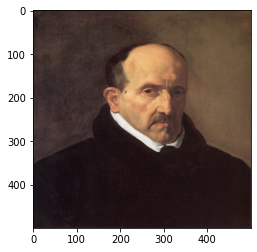

In [88]:
img = cv2.cvtColor(cv2.imread(train.img_path[0]), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (500,500))
plt.imshow(img)

In [91]:
transfomer = A.Compose([A.RandomCrop(250, 250)])

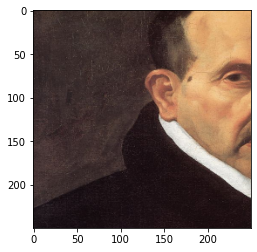

In [108]:
image = transfomer(image=img)['image']
plt.imshow(image)

In [109]:
artist_info = pd.read_csv('/content/artists_info.csv')
artist_info.head()

,name,years,genre,nationality
0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian
1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian
2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican
3,Claude Monet,1840 - 1926,Impressionism,French
4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian


In [116]:
train.loc[3896]

,img_path,artist,img_shape,width,height
id,,,,,
3896,/content/train/3896.jpg,Edgar Degas,"(709, 1024, 3)",1024,709
3896,/content/train/3986.jpg,Titian,"(753, 1024, 3)",1024,753


In [119]:
train.loc[train['img_path'] == '/content/train/3896.jpg', 'artist'] = 'Titian'
train.loc[train['img_path'] == '/content/train/3986.jpg', 'artist'] = 'Alfred Sisley'

In [125]:
train.artist.nunique()

50

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


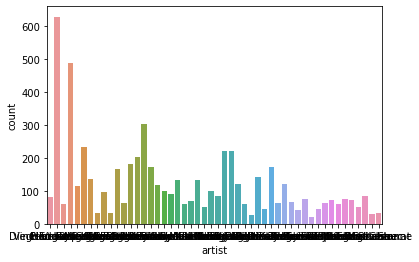

In [124]:
sns.countplot(train.artist)
plt.show()